On perlmutter: use kernel pytorch-1.13.1

In [1]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: radha-mastandrea (rmastand). Use `wandb login --relogin` to force relogin


True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split

import os
import torch

from numba import cuda 

from helpers.make_flow import *
from helpers.make_BC import *
from helpers.train_BC import *
from helpers.plotting import *
from helpers.evaluation import *

seed = 8

In [3]:
# computing

device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(32)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cuda


SBL data has shape (9966, 9).
IBL data has shape (1720, 9).
SR data has shape (35708, 9).
IBH data has shape (20791, 9).
SBH data has shape (73378, 9).


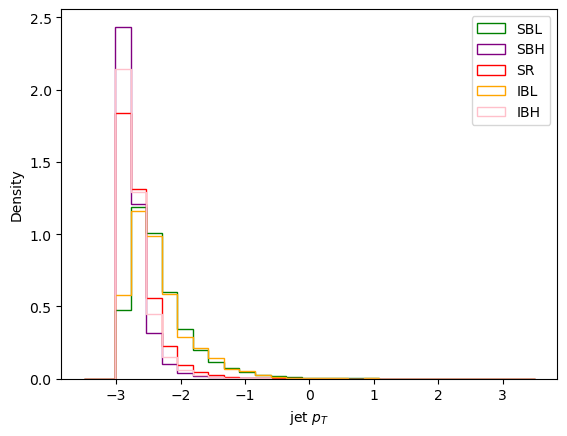

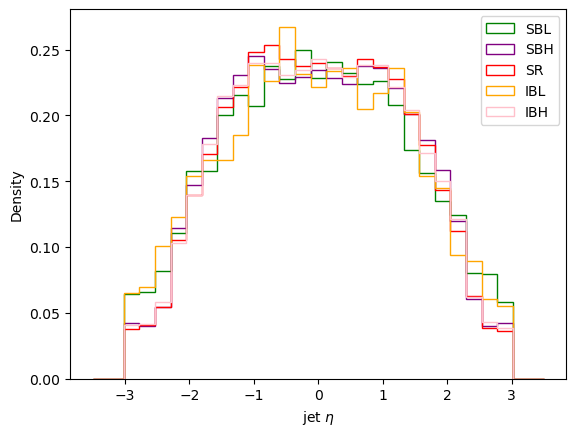

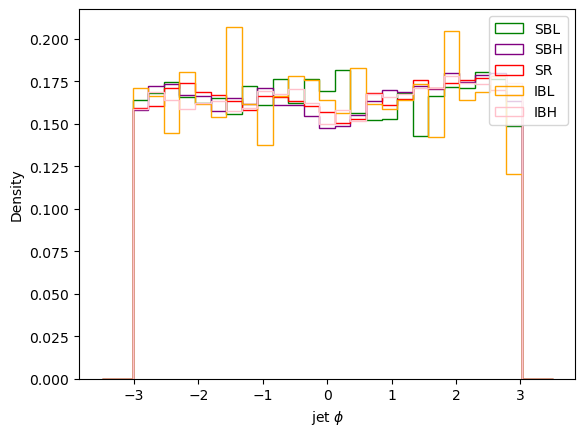

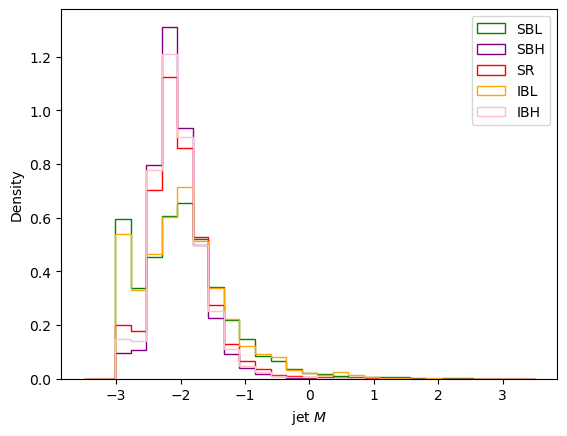

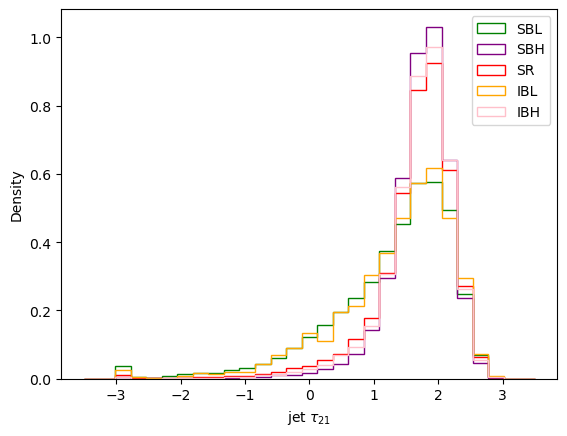

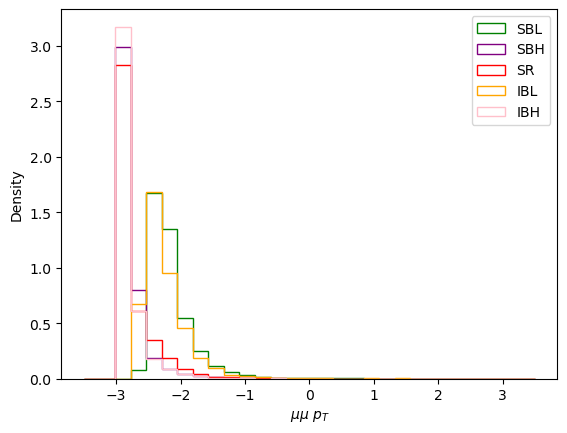

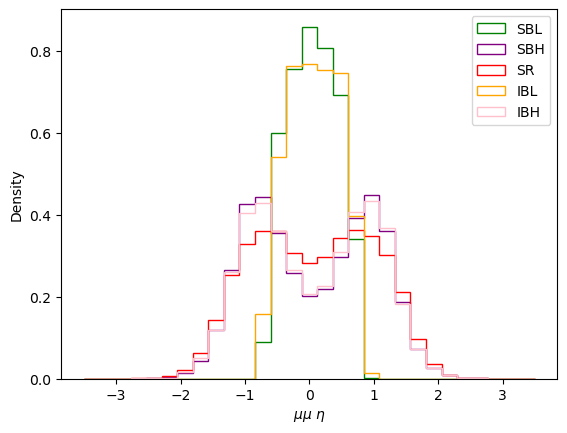

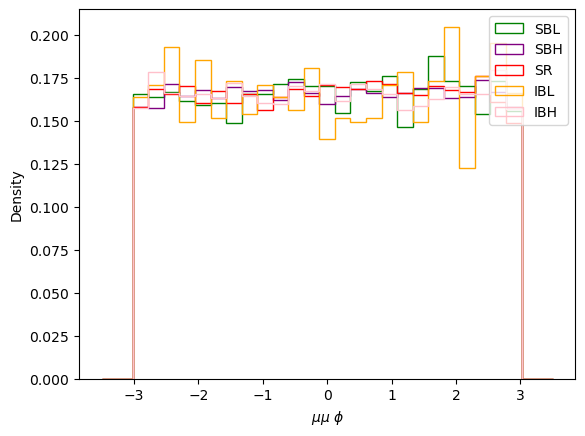

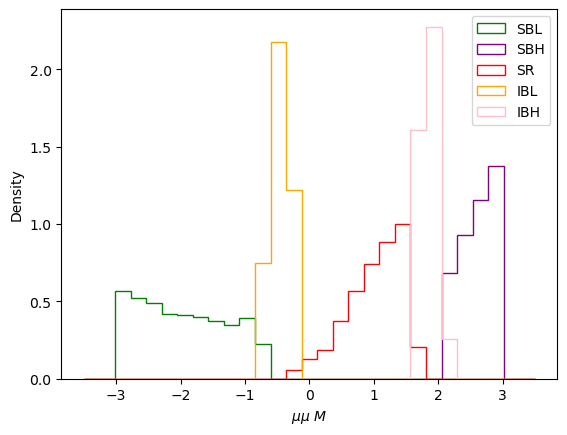

In [4]:
# load in the data

scaled_bins = [np.linspace(-3.5, 3.5, 30) for i in range(9)]

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}

for b in bands:

    data_dict[b] = np.load(f"processed_data/od_{b}_minmax.npy")
    print("{b} data has shape {length}.".format(b = b, length = data_dict[b].shape))

data_dict["SB"] =  np.vstack((data_dict["SBL"], data_dict["SBH"]))
data_dict["IB"] =  np.vstack((data_dict["IBL"], data_dict["IBH"]))

hist_all_features(["SBL", "SBH", "SR", "IBL", "IBH"], data_dict, kwargs_dict, scaled_bins)


In [5]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'bc_discrim_IB',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'num_layers': {
        'values': [1, 2, 4]
        },
    'num_hidden_features': {
        'values': [16, 32, 64, 128]
        },
    'num_blocks': {
        'values': [2, 4, 1]
        },
    'learning_rate': {
          'values': [0.001, 0.002, 0.0008]
        },
    'weight_decay': {
          'values': [ 0.0001]
        },
    'batch_size': {
          'values': [64, 32, 128]
        },
    'epochs': {
          'values': [50]
        },
    'flow_type': {
          'values': ["AR", "coupling"]
        },
    }

sweep_config['parameters'] = parameters_dict

sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-OD2")


Create sweep with ID: om7tiks2
Sweep URL: https://wandb.ai/rmastand/pytorch-sweeps-OD2/sweeps/om7tiks2


## Flow creation and training

In [7]:
def build_dataset(batch_size):
    
    SB1_train_dataset, SB1_val_dataset = train_test_split(data_dict["SBL"], test_size=0.2, random_state=seed)
    SB2_train_dataset, SB2_val_dataset = train_test_split(data_dict["SBH"], test_size=0.2, random_state=seed)

    print(f"SBL train data has shape {SB1_train_dataset.shape}.")
    print(f"SBL val data has shape {SB1_val_dataset.shape}.")
    print(f"SBH train data has shape {SB2_train_dataset.shape}.")
    print(f"SBH val data has shape {SB2_val_dataset.shape}.")
    print()
    
    # calculate the weights for the train and val datasets
    weight_SB1_train = 1. / SB1_train_dataset.shape[0]
    weight_SB1_val = 1. / SB1_val_dataset.shape[0]
    weight_SB2_train = 1. / SB2_train_dataset.shape[0]
    weight_SB2_val = 1. / SB2_val_dataset.shape[0]
        
    weights_train = [weight_SB1_train for i in range(SB1_train_dataset.shape[0])] + [weight_SB2_train for i in range(SB2_train_dataset.shape[0])]
    weights_val = [weight_SB1_val for i in range(SB1_val_dataset.shape[0])] + [weight_SB2_val for i in range(SB2_val_dataset.shape[0])]
    
    sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weights_train, len(weights_train))
    sampler_val = torch.utils.data.sampler.WeightedRandomSampler(weights_val, len(weights_val))

    train_dataset = np.vstack((SB1_train_dataset, SB2_train_dataset))    
    val_dataset = np.vstack((SB1_val_dataset, SB2_val_dataset))

    train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = 8, pin_memory = True, sampler = sampler_train)
    val_data = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers = 8, sampler = sampler_val)

    return train_data, val_data
    
    
    
def build_flow(num_features, num_layers, num_hidden_features, num_blocks, flow_type):
    
    if flow_type == "AR":
        flow = make_masked_AR_flow(num_features, num_layers, num_hidden_features, num_blocks)
    elif flow_type == "coupling":
        flow = make_coupling_flow(num_features, num_layers, num_hidden_features, num_blocks)

    pytorch_total_params = sum(p.numel() for p in flow.parameters() if p.requires_grad)
    print(f"Numb. trainable params: {pytorch_total_params}")
    
    return flow
    

def build_optimizer(flow, learning_rate, weight_decay, epochs):
    
    optimizer = optim.AdamW(flow.parameters(), lr = learning_rate, 
                            weight_decay = weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min = 0)
    
    return optimizer, scheduler

def evaluate_one_epoch(data, flow, optimizer, scheduler, train = True):
    losses_batch_per_e = []     
    for batch_ndx, data in enumerate(data):
        data = data.to(device)
        feats = data[:,:-1].float()
        cont = torch.reshape(data[:,-1], (-1, 1)).float()
        
        if train:
            optimizer.zero_grad()
            
        loss = -flow.log_prob(inputs=feats, context = cont).nanmean()  
        
        if train:
            loss.backward()
            optimizer.step()  
            scheduler.step()
        
        losses_batch_per_e.append(loss.detach().cpu().numpy())
    
    return np.nanmean(losses_batch_per_e)


In [8]:


def train(config=None):
    
    early_stop = True
    # set seeds
    torch.manual_seed(seed)
    np.random.seed(seed)

    val_loss_to_beat = 1e10
    num_features = 8

    hyperparameters_dict_BC = {"n_epochs":100,
                              "batch_size": 128,
                              "lr": 0.001,
                             }
    n_runs = 3

    
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        
        train_data, val_data = build_dataset(config.batch_size)
        flow  = build_flow(num_features, config.num_layers, config.num_hidden_features, config.num_blocks, config.flow_type)
        flow.to(device)
        optimizer, scheduler = build_optimizer(flow, config.learning_rate, config.weight_decay, config.epochs)
        if early_stop:
            early_stopping = EarlyStopping(patience = 5)
            
        # TRAIN THE FLOW
        print("Training flow...")

        for epoch in range(config.epochs):
            
            train_loss = evaluate_one_epoch(train_data, flow, optimizer, scheduler, train = True)
            wandb.log({"train_loss": train_loss, "epoch": epoch})    
            
            val_loss = evaluate_one_epoch(val_data, flow, optimizer, scheduler, train = False)
            wandb.log({"val_loss": val_loss, "epoch": epoch})    
            
            print(f"   On epoch {epoch}. Loss: {train_loss}, Val loss: {val_loss}.")
        
            # see if the model has the best val loss
            if val_loss < val_loss_to_beat:
                val_loss_to_beat = val_loss
                # save the model
                model_path = f"models/best_model.pt"
                torch.save(flow, model_path)

            if early_stop:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print(f"Done training flow! Best val loss at epoch {epoch}.")
                    print()
                    break
                    
        # EVALUATE THE FLOW IN SB
        print("Evaluating flow in SB...")

        data_dict["SBL_samples"] = sample_from_flow(model_path, device, data_dict["SBL"][:,-1])
        data_dict["SBH_samples"] = sample_from_flow(model_path, device, data_dict["SBH"][:,-1])
        data_dict["SB_samples"] =  np.vstack((data_dict["SBL_samples"], data_dict["SBH_samples"]))
        # Train a BC to discrim SB data from SB samples
        SB_data_train, SB_data_test, SB_samples_train, SB_samples_test = train_test_split(data_dict["SB"], data_dict["SB_samples"], 
                                                                                      test_size=0.15, random_state=seed)
        auc_list = []
        for i in range(n_runs):
            auc, fpr, tpr, outputs = discriminate_datasets_kfold("models/", SB_data_train[:,:-1],  SB_samples_train[:,:-1], 
                                np.ones((SB_data_train.shape[0],1)), np.ones((SB_samples_train.shape[0],1)), 
                                   SB_data_test[:,:-1], SB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 3, verbose = False)
            auc_list.append(auc)
        wandb.log({"bc_discrim_SB": np.mean(auc_list),})   
        print(auc_list)
        
        # EVALUATE THE FLOW IN IB
        print("Evaluating flow in IB...")
        
        data_dict["IBL_samples"] = sample_from_flow(model_path, device, data_dict["IBL"][:,-1])
        data_dict["IBH_samples"] = sample_from_flow(model_path, device, data_dict["IBH"][:,-1])
        data_dict["IB_samples"] =  np.vstack((data_dict["IBL_samples"], data_dict["IBH_samples"]))
        
        IB_data_train, IB_data_test, IB_samples_train, IB_samples_test = train_test_split(data_dict["IB"], data_dict["IB_samples"], 
                                                                                  test_size=0.15, random_state=seed)

        auc_list = []
        for i in range(n_runs):
            auc, fpr, tpr, outputs = discriminate_datasets_kfold("models/", IB_data_train[:,:-1],  IB_samples_train[:,:-1], 
                                np.ones((IB_data_train.shape[0],1)), np.ones((IB_samples_train.shape[0],1)), 
                                   IB_data_test[:,:-1], IB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 3, verbose = False)
            auc_list.append(auc)
        wandb.log({"bc_discrim_IB": np.mean(auc_list),})     
        
        print("All done!")


In [ ]:
wandb.agent(sweep_id, train, count=20)


wandb: Agent Starting Run: kki4ft0d with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	flow_type: AR
wandb: 	learning_rate: 0.002
wandb: 	num_blocks: 1
wandb: 	num_hidden_features: 16
wandb: 	num_layers: 4
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


SBL train data has shape (7972, 9).
SBL val data has shape (1994, 9).
SBH train data has shape (58702, 9).
SBH val data has shape (14676, 9).

Numb. trainable params: 18784
Training flow...
   On epoch 0. Loss: 8.692089080810547, Val loss: 6.683225631713867.
   On epoch 1. Loss: 6.309217929840088, Val loss: 6.05417013168335.
   On epoch 2. Loss: 6.004457473754883, Val loss: 5.9211039543151855.
   On epoch 3. Loss: 5.8846755027771, Val loss: 5.885284423828125.
   On epoch 4. Loss: 5.802061557769775, Val loss: 6.023717880249023.
   On epoch 5. Loss: 5.755550384521484, Val loss: 5.8318915367126465.
   On epoch 6. Loss: 5.736679553985596, Val loss: 5.730224609375.
   On epoch 7. Loss: 5.7016377449035645, Val loss: 5.7077813148498535.
   On epoch 8. Loss: 5.690647125244141, Val loss: 5.770069122314453.
   On epoch 9. Loss: 5.673300266265869, Val loss: 5.832391738891602.
   On epoch 10. Loss: 5.666379451751709, Val loss: 5.730380058288574.
   On epoch 11. Loss: 5.642427444458008, Val loss: 5

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]


Done training fold 0. Best val loss 0.6904162764549255 at epoch 15


 29%|██▉       | 29/100 [01:01<02:30,  2.11s/it]


Done training fold 1. Best val loss 0.6904877424240112 at epoch 24


 22%|██▏       | 22/100 [00:47<02:46,  2.14s/it]


Done training fold 2. Best val loss 0.6901921629905701 at epoch 17


 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]


Done training fold 0. Best val loss 0.6907956600189209 at epoch 14


 26%|██▌       | 26/100 [00:55<02:37,  2.12s/it]


Done training fold 1. Best val loss 0.6904105544090271 at epoch 21


 33%|███▎      | 33/100 [01:09<02:21,  2.11s/it]


Done training fold 2. Best val loss 0.689617395401001 at epoch 28


 25%|██▌       | 25/100 [00:53<02:39,  2.13s/it]


Done training fold 0. Best val loss 0.6914997100830078 at epoch 20


 27%|██▋       | 27/100 [00:57<02:35,  2.13s/it]


Done training fold 1. Best val loss 0.6900416016578674 at epoch 22


 16%|█▌        | 16/100 [00:34<03:02,  2.18s/it]


Done training fold 2. Best val loss 0.6908142566680908 at epoch 11
[0.5409446278708988, 0.551447964134409, 0.5446616015441689]
Evaluating flow in IB...
Loading in the best flow model model ...
Loading in the best flow model model ...


 22%|██▏       | 22/100 [00:11<00:41,  1.89it/s]


Done training fold 0. Best val loss 0.681864857673645 at epoch 17


 36%|███▌      | 36/100 [00:18<00:33,  1.92it/s]


Done training fold 1. Best val loss 0.6771088242530823 at epoch 31


 17%|█▋        | 17/100 [00:09<00:44,  1.87it/s]


Done training fold 2. Best val loss 0.6836701035499573 at epoch 12


 38%|███▊      | 38/100 [00:19<00:32,  1.91it/s]


Done training fold 0. Best val loss 0.6823076605796814 at epoch 33


 21%|██        | 21/100 [00:11<00:41,  1.90it/s]


Done training fold 1. Best val loss 0.6816651225090027 at epoch 16


 24%|██▍       | 24/100 [00:12<00:39,  1.91it/s]


Done training fold 2. Best val loss 0.6799193024635315 at epoch 19


 28%|██▊       | 28/100 [00:14<00:37,  1.90it/s]


Done training fold 0. Best val loss 0.6780585646629333 at epoch 23


 29%|██▉       | 29/100 [00:15<00:37,  1.92it/s]


Done training fold 1. Best val loss 0.6825315356254578 at epoch 24


 32%|███▏      | 32/100 [00:16<00:35,  1.91it/s]

Done training fold 2. Best val loss 0.6774052381515503 at epoch 27
All done!


bc_discrim_IB,▁
bc_discrim_SB,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▄▂▂▂▂▂▂▂▁▂▂▁▁▁▃▁▁▁▁▁▂▁▁
bc_discrim_IB,0.59314
bc_discrim_SB,0.54568
epoch,26
train_loss,5.55326
val_loss,5.63891


wandb: Agent Starting Run: dpc2cqhx with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	flow_type: AR
wandb: 	learning_rate: 0.0008
wandb: 	num_blocks: 1
wandb: 	num_hidden_features: 128
wandb: 	num_layers: 4
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


SBL train data has shape (7972, 9).
SBL val data has shape (1994, 9).
SBH train data has shape (58702, 9).
SBH val data has shape (14676, 9).

Numb. trainable params: 258464
Training flow...
   On epoch 0. Loss: 7.598821640014648, Val loss: 6.474740028381348.
   On epoch 1. Loss: 6.15304708480835, Val loss: 5.954212188720703.
   On epoch 2. Loss: 5.9706244468688965, Val loss: 5.8783063888549805.
   On epoch 3. Loss: 5.887409687042236, Val loss: 5.889524459838867.
   On epoch 4. Loss: 5.840854644775391, Val loss: 6.131232738494873.
   On epoch 5. Loss: 5.828117370605469, Val loss: 5.95211124420166.
   On epoch 6. Loss: 5.776077747344971, Val loss: 5.801808834075928.
   On epoch 7. Loss: 5.745593547821045, Val loss: 5.773452281951904.
   On epoch 8. Loss: 5.747725963592529, Val loss: 5.9455790519714355.
   On epoch 9. Loss: 5.728224277496338, Val loss: 5.932929992675781.
   On epoch 10. Loss: 5.708614349365234, Val loss: 5.775706768035889.
   On epoch 11. Loss: 5.681328773498535, Val los

 35%|███▌      | 35/100 [01:07<02:05,  1.92s/it]


Done training fold 0. Best val loss 0.6863937377929688 at epoch 30


 21%|██        | 21/100 [00:41<02:34,  1.95s/it]


Done training fold 1. Best val loss 0.6878952980041504 at epoch 16


 19%|█▉        | 19/100 [00:37<02:38,  1.96s/it]


Done training fold 2. Best val loss 0.6871042847633362 at epoch 14


 29%|██▉       | 29/100 [00:56<02:17,  1.93s/it]


Done training fold 0. Best val loss 0.6869009733200073 at epoch 24


 16%|█▌        | 16/100 [00:31<02:46,  1.98s/it]


Done training fold 1. Best val loss 0.6877874135971069 at epoch 11


 15%|█▌        | 15/100 [00:29<02:49,  1.99s/it]


Done training fold 2. Best val loss 0.6876425743103027 at epoch 10


 23%|██▎       | 23/100 [00:44<02:29,  1.94s/it]


Done training fold 0. Best val loss 0.6876036524772644 at epoch 18


 22%|██▏       | 22/100 [00:42<02:31,  1.94s/it]


Done training fold 1. Best val loss 0.6873986124992371 at epoch 17


 15%|█▌        | 15/100 [00:29<02:48,  1.98s/it]


Done training fold 2. Best val loss 0.6885448098182678 at epoch 10
[0.5583648833431891, 0.5583191251869706, 0.5542352705250091]
Evaluating flow in IB...
Loading in the best flow model model ...
Loading in the best flow model model ...


 10%|█         | 10/100 [00:05<00:50,  1.79it/s]


Done training fold 0. Best val loss 0.6890816688537598 at epoch 5


 14%|█▍        | 14/100 [00:07<00:46,  1.84it/s]


Done training fold 1. Best val loss 0.6875391602516174 at epoch 9


 21%|██        | 21/100 [00:11<00:41,  1.89it/s]


Done training fold 2. Best val loss 0.6862610578536987 at epoch 16


 13%|█▎        | 13/100 [00:07<00:47,  1.85it/s]


Done training fold 0. Best val loss 0.6887285113334656 at epoch 8


 16%|█▌        | 16/100 [00:08<00:44,  1.87it/s]


Done training fold 1. Best val loss 0.6885746121406555 at epoch 11


 24%|██▍       | 24/100 [00:12<00:40,  1.89it/s]


Done training fold 2. Best val loss 0.6857536435127258 at epoch 19


 23%|██▎       | 23/100 [00:12<00:40,  1.90it/s]


Done training fold 0. Best val loss 0.6851437091827393 at epoch 18


 25%|██▌       | 25/100 [00:13<00:39,  1.90it/s]


Done training fold 1. Best val loss 0.6873517036437988 at epoch 20


 11%|█         | 11/100 [00:06<00:49,  1.80it/s]

Done training fold 2. Best val loss 0.688475489616394 at epoch 6
All done!


bc_discrim_IB,▁
bc_discrim_SB,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▅▃▂▂▃▃▂▁▁▂▃▂▁▂▃▃▁▁▂▃▃▁▁▂▂▂▁
bc_discrim_IB,0.5748
bc_discrim_SB,0.55697
epoch,30
train_loss,5.5213
val_loss,5.72564


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hx1al1z1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	flow_type: coupling
wandb: 	learning_rate: 0.001
wandb: 	num_blocks: 1
wandb: 	num_hidden_features: 64
wandb: 	num_layers: 4
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


SBL train data has shape (7972, 9).
SBL val data has shape (1994, 9).
SBH train data has shape (58702, 9).
SBH val data has shape (14676, 9).

Numb. trainable params: 31952
Training flow...
   On epoch 0. Loss: 7.588335037231445, Val loss: 6.707281112670898.
   On epoch 1. Loss: 6.377970218658447, Val loss: 6.07505464553833.
   On epoch 2. Loss: 5.947601318359375, Val loss: 5.915072917938232.
   On epoch 3. Loss: 5.820502758026123, Val loss: 5.865389823913574.
   On epoch 4. Loss: 5.7562384605407715, Val loss: 5.874059200286865.
   On epoch 5. Loss: 5.701160430908203, Val loss: 5.771124362945557.
   On epoch 6. Loss: 5.676608562469482, Val loss: 5.74099063873291.
   On epoch 7. Loss: 5.648383140563965, Val loss: 5.713735103607178.
   On epoch 8. Loss: 5.639358043670654, Val loss: 5.74168586730957.
   On epoch 9. Loss: 5.6141767501831055, Val loss: 5.687987327575684.
   On epoch 10. Loss: 5.603211879730225, Val loss: 5.720070838928223.
   On epoch 11. Loss: 5.582651615142822, Val loss: 

 22%|██▏       | 22/100 [00:42<02:32,  1.95s/it]


Done training fold 0. Best val loss 0.6890286207199097 at epoch 17


 35%|███▌      | 35/100 [01:07<02:04,  1.92s/it]


Done training fold 1. Best val loss 0.6882907748222351 at epoch 30


 21%|██        | 21/100 [00:41<02:35,  1.96s/it]


Done training fold 2. Best val loss 0.689174234867096 at epoch 16


 25%|██▌       | 25/100 [00:48<02:25,  1.94s/it]


Done training fold 0. Best val loss 0.6894846558570862 at epoch 20


 22%|██▏       | 22/100 [00:42<02:32,  1.95s/it]


Done training fold 1. Best val loss 0.6895323395729065 at epoch 17


 45%|████▌     | 45/100 [01:25<01:44,  1.91s/it]


Done training fold 2. Best val loss 0.6876068115234375 at epoch 40


 29%|██▉       | 29/100 [00:55<02:16,  1.93s/it]


Done training fold 0. Best val loss 0.6893253922462463 at epoch 24


 21%|██        | 21/100 [00:41<02:35,  1.97s/it]


Done training fold 1. Best val loss 0.6897701025009155 at epoch 16


 23%|██▎       | 23/100 [00:44<02:29,  1.94s/it]


Done training fold 2. Best val loss 0.6887310147285461 at epoch 18
[0.558159227558305, 0.5565434854371469, 0.5472746149129977]
Evaluating flow in IB...
Loading in the best flow model model ...
Loading in the best flow model model ...


 14%|█▍        | 14/100 [00:07<00:46,  1.85it/s]


Done training fold 0. Best val loss 0.687045156955719 at epoch 9


 24%|██▍       | 24/100 [00:12<00:40,  1.90it/s]


Done training fold 1. Best val loss 0.6804829239845276 at epoch 19


 17%|█▋        | 17/100 [00:09<00:44,  1.87it/s]


Done training fold 2. Best val loss 0.6844858527183533 at epoch 12


 33%|███▎      | 33/100 [00:17<00:35,  1.91it/s]


Done training fold 0. Best val loss 0.6843822598457336 at epoch 28


 26%|██▌       | 26/100 [00:13<00:38,  1.90it/s]


Done training fold 1. Best val loss 0.6837222576141357 at epoch 21


 24%|██▍       | 24/100 [00:12<00:40,  1.90it/s]


Done training fold 2. Best val loss 0.6816114187240601 at epoch 19


 28%|██▊       | 28/100 [00:14<00:37,  1.90it/s]


Done training fold 0. Best val loss 0.6821401119232178 at epoch 23


 25%|██▌       | 25/100 [00:13<00:39,  1.90it/s]


Done training fold 1. Best val loss 0.6823176741600037 at epoch 20


 31%|███       | 31/100 [00:16<00:35,  1.92it/s]

Done training fold 2. Best val loss 0.683600902557373 at epoch 26
All done!


bc_discrim_IB,▁
bc_discrim_SB,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁
bc_discrim_IB,0.58308
bc_discrim_SB,0.55399
epoch,20
train_loss,5.5222
val_loss,5.7025


wandb: Agent Starting Run: z4xdolqx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	flow_type: coupling
wandb: 	learning_rate: 0.0008
wandb: 	num_blocks: 1
wandb: 	num_hidden_features: 128
wandb: 	num_layers: 1
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


SBL train data has shape (7972, 9).
SBL val data has shape (1994, 9).
SBH train data has shape (58702, 9).
SBH val data has shape (14676, 9).

Numb. trainable params: 15860
Training flow...
   On epoch 0. Loss: 14.709724426269531, Val loss: 14.020059585571289.
   On epoch 1. Loss: 13.891682624816895, Val loss: 13.734539985656738.
   On epoch 2. Loss: 13.60976505279541, Val loss: 13.490870475769043.
   On epoch 3. Loss: 13.482027053833008, Val loss: 13.436468124389648.
   On epoch 4. Loss: 13.418169021606445, Val loss: 13.454039573669434.
   On epoch 5. Loss: 13.383245468139648, Val loss: 13.375248908996582.
   On epoch 6. Loss: 13.361945152282715, Val loss: 13.401524543762207.
   On epoch 7. Loss: 13.363204956054688, Val loss: 13.417820930480957.
   On epoch 8. Loss: 13.350666999816895, Val loss: 13.395340919494629.
   On epoch 9. Loss: 13.344659805297852, Val loss: 13.365796089172363.
   On epoch 10. Loss: 13.340045928955078, Val loss: 13.364320755004883.
   On epoch 11. Loss: 13.3491

 43%|████▎     | 43/100 [01:21<01:48,  1.90s/it]


Done training fold 0. Best val loss 0.04603704810142517 at epoch 38


 33%|███▎      | 33/100 [01:03<02:08,  1.92s/it]


Done training fold 1. Best val loss 0.04637559503316879 at epoch 28


 27%|██▋       | 27/100 [00:51<02:20,  1.92s/it]


Done training fold 2. Best val loss 0.04463436082005501 at epoch 22


 13%|█▎        | 13/100 [00:26<02:54,  2.00s/it]


Done training fold 0. Best val loss 0.04818544536828995 at epoch 8


 37%|███▋      | 37/100 [01:10<01:59,  1.90s/it]


Done training fold 1. Best val loss 0.0461164265871048 at epoch 32


 23%|██▎       | 23/100 [00:44<02:29,  1.95s/it]


Done training fold 2. Best val loss 0.04642530903220177 at epoch 18


 46%|████▌     | 46/100 [01:27<01:42,  1.91s/it]


Done training fold 0. Best val loss 0.04536119103431702 at epoch 41


 38%|███▊      | 38/100 [01:12<01:58,  1.91s/it]


Done training fold 1. Best val loss 0.04279688745737076 at epoch 33


 52%|█████▏    | 52/100 [01:39<01:31,  1.90s/it]


Done training fold 2. Best val loss 0.04302988946437836 at epoch 47
[0.9984534933217277, 0.9985735924869201, 0.9985068330516486]
Evaluating flow in IB...
Loading in the best flow model model ...
Loading in the best flow model model ...


 18%|█▊        | 18/100 [00:09<00:44,  1.86it/s]


Done training fold 0. Best val loss 0.047757528722286224 at epoch 13


 27%|██▋       | 27/100 [00:14<00:38,  1.91it/s]


Done training fold 1. Best val loss 0.04464048892259598 at epoch 22


 40%|████      | 40/100 [00:20<00:31,  1.93it/s]


Done training fold 2. Best val loss 0.035237573087215424 at epoch 35


 25%|██▌       | 25/100 [00:13<00:39,  1.90it/s]


Done training fold 0. Best val loss 0.0461987741291523 at epoch 20


 31%|███       | 31/100 [00:16<00:36,  1.91it/s]


Done training fold 1. Best val loss 0.039958707988262177 at epoch 26


 35%|███▌      | 35/100 [00:18<00:33,  1.92it/s]


Done training fold 2. Best val loss 0.04212285578250885 at epoch 30


 38%|███▊      | 38/100 [00:19<00:32,  1.92it/s]


Done training fold 0. Best val loss 0.044619809836149216 at epoch 33


 28%|██▊       | 28/100 [00:14<00:37,  1.91it/s]


Done training fold 1. Best val loss 0.04147842898964882 at epoch 23


 25%|██▌       | 25/100 [00:13<00:39,  1.90it/s]

Done training fold 2. Best val loss 0.04116528108716011 at epoch 20
All done!


bc_discrim_IB,▁
bc_discrim_SB,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁
bc_discrim_IB,0.9985
bc_discrim_SB,0.99851
epoch,22
train_loss,13.2775
val_loss,13.32664


wandb: Agent Starting Run: oo9hl5n7 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	flow_type: AR
wandb: 	learning_rate: 0.0008
wandb: 	num_blocks: 4
wandb: 	num_hidden_features: 128
wandb: 	num_layers: 4
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


SBL train data has shape (7972, 9).
SBL val data has shape (1994, 9).
SBH train data has shape (58702, 9).
SBH val data has shape (14676, 9).

Numb. trainable params: 657824
Training flow...
   On epoch 0. Loss: 7.205650329589844, Val loss: 6.204926490783691.
   On epoch 1. Loss: 6.153870582580566, Val loss: 6.094123363494873.
   On epoch 2. Loss: 6.001318454742432, Val loss: 6.032041549682617.
   On epoch 3. Loss: 5.918058395385742, Val loss: 5.818963527679443.
   On epoch 4. Loss: 5.8621931076049805, Val loss: 5.984384536743164.
   On epoch 5. Loss: 5.815484046936035, Val loss: 5.835422992706299.
   On epoch 6. Loss: 5.771085262298584, Val loss: 5.954775810241699.
   On epoch 7. Loss: 5.731719493865967, Val loss: 5.781330108642578.
